## Setup + Imports

In [ ]:
# Imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


## Read in Data

In [ ]:
# Read in and Store Movie Script Character Metadata
# Source: https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html
p = Path("movie_characters_metadata.txt")

Lines = []
rows_list = []

# with p.open() as f:
#   Lines = f.readlines()

with open(p, 'rb') as f:
  for line in f:
      Lines.append(line.decode(errors='ignore'))
  
# Strips the newline character
for line in Lines:
  string_data = line.replace(' +++$+++ ',',')
  rows_list.append([x.split(',') for x in string_data.split('\n')])

entries = []

for i in range(0, len(rows_list)):
  entries.append(rows_list[i][0])

df_script_metadata = pd.DataFrame(entries)

In [ ]:
p_lines = Path("movie_lines.txt")

movie_lines = []
trimmed_movie_lines = []

# TODO: Rough way to process, but may want to revisit due to string reading errors and make sure processing ok.
with open(p_lines, 'rb') as f:
  for line in f:
      movie_lines.append(line.decode(errors='ignore'))
  
# Strips the newline character
for line in movie_lines:
  string_data = line.replace(' +++$+++ ',',')
  trimmed_movie_lines.append([x.split(',') for x in string_data.split('\n')])

movie_line_entries = []

for i in range(0, len(trimmed_movie_lines)):
  movie_line_entries.append(trimmed_movie_lines[i][0])

df_movie_lines = pd.DataFrame(movie_line_entries)


In [ ]:
# Read in and Store MBTI values for Each Character
# Source: https://www.kaggle.com/subinium/movie-character-mbti-dataset
df_mbti = pd.read_csv("mbti.csv")

## Determine Movie Intersection Between Data

In [ ]:
unique_script_movies = df_script_metadata[3].unique()
print(f"There are {len(unique_script_movies)} unique movies in the script data.")

There are 617 unique movies in the script data.


In [ ]:
# Need to remove the dates from () to be comparable with script movie titles.
# Cannot just remove numbers as some movie titles have numbers in them.
unique_mbti_movies = df_mbti['movie'].str.replace(r"\(.*\)","").str.lower().str.strip().unique()
print(f"There are {len(unique_mbti_movies)} unique movies in the mbti data.")

There are 3072 unique movies in the mbti data.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Get the intersection between both movie lists.
movie_intersection = [x for x in unique_mbti_movies if x in unique_script_movies]
print(f"There are {len(movie_intersection)} unique movies in both datasets.")

There are 254 unique movies in both datasets.


## Get the Characters Intersection for Movies in Both Lists

In [ ]:
df_mbti['movie_clean'] = df_mbti['movie'].str.replace(r"\(.*\)","").str.lower().str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
df_script_intersection = df_script_metadata[df_script_metadata[3].isin(movie_intersection)]
df_mbti_intersection = df_mbti[df_mbti['movie_clean'].isin(movie_intersection)]

# Check that filtering done correctly.
print(f"There are {len(df_script_intersection[3].unique())} unique movies in the script data.")
print(f"There are {len(df_mbti_intersection['movie_clean'].unique())} unique movies in the mbti data.")


There are 254 unique movies in the script data.
There are 254 unique movies in the mbti data.


In [ ]:
df_mbti_intersection["char_name"] = df_mbti_intersection.role.str.split().str.get(0).str.upper()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# There is an issue with the character names as script only has first name 
# and mbti has both first and last name.

# Relatively basic way is to lowercase the first name and just match based on that.
# Problem is that if there are two characters with the same name in a movie or for Dr. Heywood Floyd 
# which is just Floyd in the script dat.

# For basic estimation, I'll just use the basic way for now. 
# If we proceed with these data, then we can do manual comparison or something to address those edge cases too.

# TODO: Revisit how we merge the two characters (could potentially increase the dataset).
df_both_chars = pd.merge(left=df_script_intersection, right=df_mbti_intersection, left_on=[3, 1], right_on=['movie_clean', 'char_name'])


## Get the Number of Characters for Each MBTI

In [ ]:
df_mbti_grouped = df_both_chars.groupby('mbti').count()[0]

print(f"The average number of characters in a group is {round(df_mbti_grouped.mean(), 1)}")
print(f"The min number of characters in a group is {df_mbti_grouped.min()}")
print(f"The max number of characters in a group is {df_mbti_grouped.max()}")

The average number of characters in a group is 49.6
The min number of characters in a group is 24
The max number of characters in a group is 81


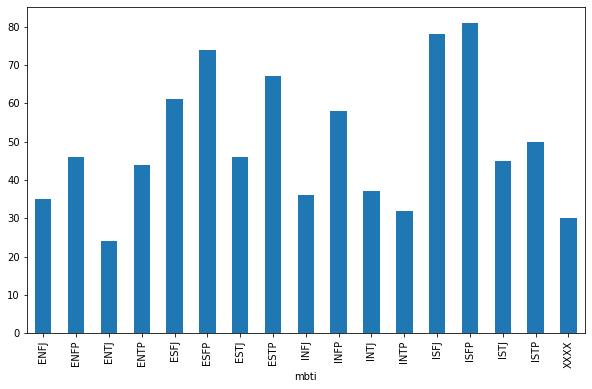

In [ ]:
ax = df_mbti_grouped.plot(kind='bar', figsize=(10,6));
plt.show()

## Get the Number of Script Lines for Each Character in MBTI

In [ ]:
df_movie_lines["characterID"] = df_movie_lines[1]

df_lines_w_mbti = pd.merge(left=df_movie_lines, right=df_both_chars, how='left', left_on=['characterID'], right_on=[0])

In [ ]:
df_lines_w_mbti.describe()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,characterID,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,stat,mbti,enneagram,role,movie,img_url,movie_clean,char_name
count,311483,311483,311483,311483,311483,109145,36265,13861,6350,3253,1796,1082,695,444,319,211,144,98,76,61,44,32,24,18,16,13,9,6,5,5,4,4,3,3,3,3,3,2,2,2,1,1,1,1,1,1,1,1,311483,64457,64457,64457,64457,64457,64457,0,0,64325,64457,49139,64457,64457,64457,64457,64457
unique,304713,9035,617,5356,224483,84730,32006,12581,5898,3058,1705,1034,655,422,306,205,140,97,74,60,44,32,24,18,16,13,9,6,5,5,4,4,3,3,3,3,3,2,2,2,1,1,1,1,1,1,1,1,9035,754,563,227,227,5,26,0,0,238,17,18,752,236,546,227,563
top,L542232,u7713,m289,JACK,Well,sir.,you know,you know,you know,you know,you know,uh,you know,sir,nonsinging motherfucker.,a few days before you get transferred to an a...,you grant an interview on television with Way...,we'll shame 'em into dropping the whole thing...,like,whatta ya say?,somehow pass along a message to let the paren...,doing alright.,and hardcore films'll be medical films. Peopl...,but I hear they're magnificent. Very big spec...,huge mothers -- and white as snow,to coin a phrase,except for black tips on their wings and tail...,and bright red heads. Now,whooping cranes,in case you didn't know it,are noted for their mating dance. It's just t...,beautiful,gigantic birds in full dance -- leaping six f...,arching their backs,flapping their wings,strutting low to the ground. Dears,it's overwhelming. And picture the birds doin...,creation's most elaborate sex ritual -- yet c...,red hood attached,and big feathery sleeves trimmed in black. In...,she dance/walks over to a large nest in which...,a string quartet is playing Debussy. A sensuo...,lyrical,erotic and Girl Scout- oriented; you can't to...,the best wildlife cinematographers around. Yo...,not even if she had your personality which sh...,dear,I'm out of photography now and into water col...,u7713,u7713,JOE,m522,some like it hot,m,1,NaN,NaN,1 / 0,INFP,6w5,Joe / Josephine / Shell Oil Junior,Some Like It Hot (1959),https://www.personality-database.com/images/pr...,some like it hot,JOE
freq,5,688,1853,3112,4609,671,112,58,36,22,13,7,8,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,688,688,1273,1278,1278,35843,23826,NaN,NaN,6008,6729,5924,688,1278,15592,1278,1273


In [ ]:
print(f"The total number of lines is {df_lines_w_mbti.count()['mbti']}")

df_lines_w_mbti_grouped = df_lines_w_mbti.groupby('mbti').count()['0_x']

print(f"The average number of lines in a group is {round(df_lines_w_mbti_grouped.mean(), 1)}")
print(f"The min number of lines in a group is {df_lines_w_mbti_grouped.min()}")
print(f"The max number of lines in a group is {df_lines_w_mbti_grouped.max()}")

The total number of lines is 64457
The average number of lines in a group is 3791.6
The min number of lines in a group is 2292
The max number of lines in a group is 6729


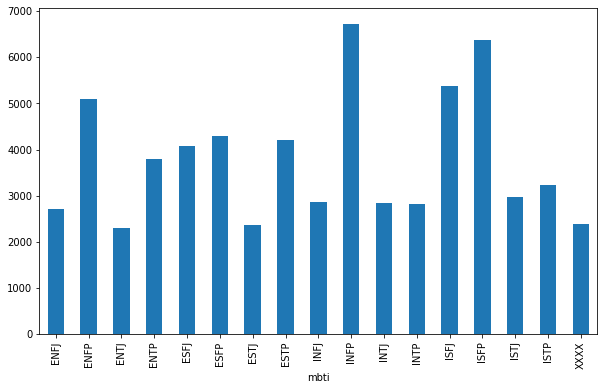

In [ ]:
ax = df_lines_w_mbti_grouped.plot(kind='bar', figsize=(10,6));
plt.show()

## Save data as csv

In [ ]:
df_lines_w_mbti["text"] = df_lines_w_mbti["4_x"]
df_data = df_lines_w_mbti[["text", "role", "movie_clean", "mbti"]].dropna()

In [ ]:
df_data

,text,role,movie_clean,mbti
0,They do not!,Bianca Stratford,10 things i hate about you,ESFJ
1,They do to!,Cameron James,10 things i hate about you,INFP
2,I hope so.,Bianca Stratford,10 things i hate about you,ESFJ
3,She okay?,Cameron James,10 things i hate about you,INFP
4,Let's go.,Bianca Stratford,10 things i hate about you,ESFJ
...,...,...,...,...
311389,Look how far we've come.,Inga,young frankenstein,ESFP
311391,I'm getting tired.,Inga,young frankenstein,ESFP
311393,It's working! Oh,Inga,young frankenstein,ESFP
311395,His schwanzstucker.,Inga,young frankenstein,ESFP


In [ ]:
# Save data as csv.
df_data.to_csv("data.csv")